# Load Dependencies 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import Data

In [2]:
from sklearn.model_selection import train_test_split

train = pd.read_csv('Data/train_features.csv')
X_test = pd.read_csv('Data/test_features.csv')
target = pd.read_csv('Data/train_labels.csv')
label = target['status_group']

# Only used to test collapsing problem to binomial classification
target['encoded'] = target['status_group'].replace({
    'functional': 2,
    'non functional': 0,
    'functional needs repair':1
})

X_train, X_val, y_train, y_val = train_test_split(train, label, test_size = 0.2, random_state = 42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (14358, 40), (47520,), (11880,))

# Data Dictionary 

In [3]:
data_dict = pd.read_excel('Data_Dictionary.xlsx', skipfooter=3)
data_dict

,Index,Feature,Description,Dtype,% NA?,Unique values,Correlation w/Target,Hypothesis,Baseline Approach,Notes
0,1,amount_tsh,Amount of water available to waterpoint,float,NaN,98,0.0530,Important,Standardize Data,"Highly Positive Skew (70% = 0), should address..."
1,2,date_recorded,The data the observation was entered,object,NaN,356,NaN,Important,Create columns for month and year,Recording from 10/2002 to 12/2013
2,3,funder,who funded the wall,object,0.0610,1897,NaN,Moderate,Ignore,"Long Tail of funders, consider binning, invest..."
3,4,gps_height,altitude of the well,int,NaN,2428,0.1100,Important,Standardize Data,Distribution positively skewed
4,5,installer,orgaization that installed the well,object,0.0610,2145,NaN,Important,Ignore,"31% installed by same group, long-tail of smal..."
5,6,longitude,GPS coordinate,float,NaN,57516,-0.0040,Moderate,Ignore,Weird distribution of values near zero (error?...
6,7,latitude,GPS coordinate,float,NaN,57517,0.0140,Moderate,Ignore,NaN
7,8,wpt_name,Name of the waterpoint if there is one,object,NaN,37400,NaN,Low,Ignore,6% of obs. Have value of 'none'
8,9,num_private,?,int,NaN,65,0.0005,Low,Ignore,98% of values = 0
9,10,basin,Geographic water basin,object,NaN,9,NaN,Low,One Hot Encode,Majority category is 17% of population


# Select Features

In [4]:
selected_features = ['amount_tsh',
    'date_recorded',
    'gps_height',
    'basin',
    'region',
    'district_code',
    'population',
#     'public_meeting',
#     'scheme_management',
#     'permit',
    'construction_year',
    'extraction_type_class',
    'management_group',
    'payment',
    'quality_group',
    'quantity',
    'source_type',
    'source_class', 
    'waterpoint_type',
    'funder',
    'installer', 
    'latitude',
    'longitude']

def select_features(df, features):
    '''
    Subsets dataframe based on list of columns names accepted 
    as a parameter.
    '''
    return df[features]

In [5]:
X_train = select_features(X_train, features=selected_features)
X_val = select_features(X_val, features=selected_features)
X_test = select_features(X_test, features=selected_features)
X_train.shape, X_val.shape, X_test.shape

((47520, 20), (11880, 20), (14358, 20))

# Encode Target

In [6]:
# Only used to test collapsing problem to binomial classification
target['encoded'] = target['status_group'].replace({
    'functional': 1,
    'non functional': 0,
    'functional needs repair':0
})

# Process Features 

### Impute Features

In [7]:
def smart_impute(X):
    ''' Adapted directly from Dakota P.'s awesome work '''
    X = X.copy()
    
    # Convert all strings in object columns to lowercase
    cat_features = X.select_dtypes('object').columns.tolist()
    for feature in cat_features:
        X[feature] = X[feature].str.lower()
    
    # Replace -2.000000e-08 with np.nan (not showing as zero due to datatype)
    X['latitude'] = X['latitude'].replace( -2.000000e-08, np.nan)
    
    impute_features = ['gps_height', 'population', 'amount_tsh', 'construction_year', 'latitude', 'longitude']

    for feature in impute_features:
        # Replace values=0.0 with np.nan (0.0 appears to indicate missing values in dataset)
        X[feature] = X[feature].replace(0, np.nan)
        
        # Note, hardcoded train when calculating mean to avoid leakage into test data
        # If District code available replace NA's with mean value of other well in the same district 
        X[feature] = X[feature].fillna( X.groupby(['region', 'district_code'])[feature].transform('mean') )
        # If no district code, replace NA's  with mean value of other wells in the same region
        X[feature] = X[feature].fillna( X.groupby(['region'])[feature].transform('mean') )
        # If no district and no region, replace NA's with mean value of all wells
        X[feature] = X[feature].fillna( X[feature].mean() )
    
    # Convert Boolean Features to int
    
    return X

In [8]:
X_train = smart_impute(X_train)
X_val = smart_impute(X_val)
X_test = smart_impute(X_test)
X_train.shape, X_val.shape, X_test.shape

((47520, 20), (11880, 20), (14358, 20))

# Wrangle Features

In [9]:
def wrangle_features(X):
    X = X.copy()

    # Create features to capture well distance from other wells
#     long_mean = X_train['longitude'].mean()
#     lat_mean = X_train['latitude'].mean()
#     X['distance'] = np.sqrt((X['longitude'] - long_mean)**2 + 
#                                   (X['latitude'] - lat_mean)**2)
#     X['distance_height'] = np.sqrt((X['gps_height']**2 + X['longitude'] - long_mean)**2 + 
#                                          (X['latitude'] - lat_mean)**2)
    
# #     # Create month and year features from the recorded data feature
#     X['date_recorded'] = pd.to_datetime(X['date_recorded'])
# #     X['date_recorded_month'] = X['date_recorded'].dt.month
#     X['date_recorded_year'] = X['date_recorded'].dt.year
    
#     # Years since construction feature
#     X['Years_Since_built'] = X['construction_year'] - X['date_recorded_year']
    
#     # Create feature for seasons in Tanzania
#     X['Hot_Dry_Season'] = (X['date_recorded_month'] == 12) | (X['date_recorded_month'] < 3)
#     X['Heavy_Rain_Season'] = (X['date_recorded_month'] > 4) & (X['date_recorded_month'] < 6)
#     X['Cool_Dry_Season'] = (X['date_recorded_month'] > 5) & (X['date_recorded_month'] < 11)
#     X['Moderate_Rain'] = (X['date_recorded_month'] == 11) | (X['date_recorded_month'] == 3)
    
    # Bin low freq. categories into 'other' 
#     X['scheme_management'] = X['scheme_management'].replace({
#         'SWC':'Other',
#         'Trust':'Other',
#         'None':'Other'
#     })
    
    # Create unkown category for missing values in scheme management column
#     X['scheme_management'] = X['scheme_management'].fillna('unknown')
#     X['permit'] = X['permit'].fillna(False)
#     X['public_meeting'] = X['public_meeting'].fillna(True)
    
    # Create age category out of construction_year
    # Bin 0 values as -1
#     X['pump_age'] = ( 2014 - X['construction_year'] )
#     X['pump_age'] = X['pump_age'].replace({2014:-1})
    
#     # Create Installer Features
#     X['DWE_Installer'] = (X['installer'] == 'DWE')
#     X['Gov_Installer'] = (X['installer'] == 'Government')

#     one_time_install = train['installer'].value_counts()[train['installer'].value_counts() == 1]
#     X['One_Time_Installer'] = X['installer'].isin(one_time_install.index)

#     small_install = train['installer'].value_counts()[ (train['installer'].value_counts() < 10) & (train['installer'].value_counts() > 1) ]
#     X['Small_Installer'] = X['installer'].isin(small_install.index)

#     big_install = (( train['installer'].value_counts() >= 10 ) == True)
#     X['Big_Installer'] = X['installer'].isin(big_install.index)
    
#     # Create Funder Features
#     X['Tanzania_Gov_Funder'] = (X['funder'] == 'Government Of Tanzania')

#     one_time_funder = train['funder'].value_counts()[train['funder'].value_counts() == 1]
#     X['One_Time_Funder'] = X['funder'].isin(one_time_funder.index)

#     small_funder = train['funder'].value_counts()[ (train['funder'].value_counts() < 10) & (train['funder'].value_counts() > 1) ]
#     X['Small_Funder'] = X['funder'].isin(small_funder.index)

#     big_funder = (( train['funder'].value_counts() >= 10 ) == True)
#     X['Big_Funder'] = X['funder'].isin(big_funder.index)
    
#     # Create interaction between amount of water avaialable and population
#     X['pop*amount_tsh'] = X['population'] * X['amount_tsh']
#     X['pop/amount_tsh'] = X['population'] / X['amount_tsh']
#     X['pop/amount_tsh'] = X['pop/amount_tsh'].replace(np.inf, 3000)
    
#     X['pop**2'] = X['population'] ** 2
    
#     # Create interaction between amount of water avaialable and height
#     X['gps_height*amount_tsh'] = X['gps_height'] * X['amount_tsh']
    
#     # Polynomial gps_Height
#     X['gps_height**2'] = X['gps_height'] ** 2
#     X['gps_height**3'] = X['gps_height'] ** 3
    
#     # Interaction between latitude and height
#     X['latitude*height*amount'] = X['latitude'] * X['gps_height'] * X['amount_tsh']
#     X['latitude*height'] = X['latitude'] * X['gps_height']
    
#     # Create Binned Features
#     labels = [1,2,3,4,5,6,7,8,9,10]
#     X['gps_height_binned'] = pd.cut(x=X['gps_height'], bins=10, labels=labels)
#     X['pump_age_binned'] = pd.cut(x=X['pump_age'], bins=10, labels=labels)
#     X['amount_tsh_binned'] = pd.cut(x=X['amount_tsh'], bins=10, labels=labels)
#     X['longitude_binned'] = pd.cut(x=X['longitude'], bins=10, labels=labels)
#     X['latitude_binned'] = pd.cut(x=X['latitude'], bins=10, labels=labels)
    
#     # Convert Binned Features to int datatype
#     X['gps_height_binned'] = X['gps_height_binned'].astype(int)
#     X['pump_age_binned'] = X['pump_age_binned'].astype(int)
#     X['amount_tsh_binned'] = X['amount_tsh_binned'].astype(int)
#     X['longitude_binned'] = X['longitude_binned'].astype(int)
#     X['latitude_binned'] = X['latitude_binned'].astype(int)
    
#     # Pumps Funded and Built by Tanzania Government
#     X['Gov_Funded_Gov_Built'] = X['Tanzania_Gov_Funder'] * X['DWE_Installer'].astype(int)
    
    return X

In [10]:
X_test = wrangle_features(X_test)
X_val = wrangle_features(X_val)
X_train = wrangle_features(X_train)

X_train.shape, X_val.shape, X_test.shape

((47520, 20), (11880, 20), (14358, 20))

# Create Composite Scores (Additional Feature Engineering) 

In [11]:
def create_score(X, feature):
    rel_score = pd.crosstab(X_train[feature], y_train)
    rel_score = pd.DataFrame(rel_score)
    
    new_feature = feature + '_rel_score'
    total = rel_score['functional'] + rel_score['functional needs repair'] + rel_score['non functional']
    rel_score[new_feature] = rel_score['functional'] / total
    
    rel_score = rel_score.reset_index()
    rel_score = rel_score[ [feature, new_feature] ]
    
    X = pd.merge(X, rel_score, how='left', on=feature)
    X[new_feature] = X[new_feature].fillna(0)
    
    return X

In [12]:
def composite_scores(X):
    X = X.copy()
    
    # Create Reliability Scores
    rel_cols = ['installer', 'scheme_management', 'management_group', 'payment', 'extraction_type_class',
               'waterpoint_type', 'pump_age_binned', 'gps_height_binned', 'amount_tsh_binned', 'longitude_binned',
               'latitude_binned', 'region', 'basin', 'district_code']
    
    for col in rel_cols:
        X = create_score(X, col)
    
    # Create Composite Scores
    X['Management_Score'] = X['installer_rel_score'] + X['scheme_management_rel_score'] + X['management_group_rel_score']
    X['Condition_Score'] = X['gps_height_binned_rel_score'] + X['amount_tsh_binned_rel_score'] + X['latitude_binned_rel_score'] + X['longitude_binned_rel_score']
    X['Tech_Score'] = X['payment_rel_score'] + X['pump_age_binned_rel_score'] + X['extraction_type_class_rel_score'] + X['waterpoint_type_rel_score']
    
    X['Overall_Reliability_Score'] = X['Management_Score'] + X['Condition_Score'] + X['Tech_Score']
    X['Overall_Reliability_Score**2'] = X['Overall_Reliability_Score'] ** 2 
    
    # Public Support Score 
    X['Public_Support'] = X['payment_rel_score'] + X['public_meeting'] + X['permit']
    
    # Location Score
    X['Location_Score'] = X['basin_rel_score'] + X['district_code_rel_score'] + X['region_rel_score']
    
    # Location * Condition
    X['Location*Condition'] = X['Location_Score'] + X['Condition_Score']
    X['Location*Condition**2'] = X['Location*Condition'] ** 2
    
    # Public Support and Location
    X['Public_Support+Loc'] = X['Public_Support'] + X['Location_Score']
    
    # Site Score
    X['Site_Score'] = X['Location_Score'] + X['Public_Support'] + X['Overall_Reliability_Score']
    X['Site_Score**2'] = X['Site_Score'] ** 2
    
    # Negative Correlated Features
    X['dry&high'] = (X['Hot_Dry_Season'] | X['Cool_Dry_Season']) * X['latitude*height']
    X['Pump_Age*Pop/Amount_tsg'] = X['pump_age'] * X['pop/amount_tsh']
    X['pump_age_binned**2'] = X['pump_age_binned'] ** 2
    
    return X

In [13]:
# X_train = composite_scores(X_train)
# X_val = composite_scores(X_val)
# X_test = composite_scores(X_test)

# X_train.shape, X_val.shape, X_test.shape

In [14]:
def drop_cols(X):
    X = X.copy()
    
    # Drop unecessary columns
    drop_cols = ['date_recorded', 'funder', 'installer', 'construction_year']
    X = X.drop(columns=drop_cols)
    
    return X

In [15]:
X_train = drop_cols(X_train)
X_val = drop_cols(X_val)
X_test = drop_cols(X_test)

X_train.shape, X_val.shape, X_test.shape

((47520, 16), (11880, 16), (14358, 16))

# Encode Features 

### One Hot Encoding

In [16]:
import category_encoders as ce

def one_hot(X_train, X_val, X_test):
    # Features to one hot encode
    one_hot_cols = ['extraction_type_class', 'payment', 'quality_group', 
                    'quantity', 'source_class', 'waterpoint_type', 'basin', 'source_type', 'region', 
                    'management_group']
    
    # Initialize and transform relevant features
    encoder = ce.OneHotEncoder(cols=one_hot_cols, use_cat_names=True)
    
    # Note, train hardcoded to avoid overfitting test data
    encoder.fit(X_train)
    train_encoded = encoder.transform(X_train)
    val_encoded = encoder.transform(X_val)
    test_encoded = encoder.transform(X_test)
    
    train_encoded, val_encoded = train_encoded.align(val_encoded, join='left', axis=1)
    train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1)
    
    return train_encoded, val_encoded, test_encoded

In [17]:
X_train, X_val, X_test = one_hot(X_train, X_val, X_test)

X_train.shape, X_val.shape, X_test.shape

((47520, 83), (11880, 83), (14358, 83))

In [18]:
X_train.columns.tolist() == X_val.columns.tolist() == X_test.columns.tolist()

True

### Ordinal Encoding

In [19]:
import category_encoders as ce

def ordinal(X):
    ord_cols = ['extraction_type_class', 'payment', 'quality_group', 
                    'quantity', 'source_class', 'waterpoint_type', 'basin', 'source_type', 'region', 'scheme_management',
                    'management_group']
    
    # Initialize and transform relevant features
    encoder = ce.OrdinalEncoder(cols=ord_cols)
    
    # Note, train hardcoded to avoid overfitting test data
    encoder.fit(X_train)
    X = encoder.transform(X)
    
    return X

In [20]:
# X_train = ordinal(X_train)
# X_val = ordinal(X_val)
# X_test = ordinal(X_test)

# X_train.shape, X_val.shape, X_test.shape

### Create Additional Features Based on Encoded Features 

- Only intended to be used with OneHotEncoding

In [21]:
def non_func_features(X):
    X = X.copy()
    
    # Convert boolean cols to ints
    X = X.applymap(lambda x: 1 if x == True else x)
    X = X.applymap(lambda x: 0 if x == False else x)
    
    X['quantity_dry*pump_age/amount'] = X['quantity_dry'] / X['Pump_Age*Pop/Amount_tsg']
    
    X['Condition_Risk'] = X['quantity_dry'] + X['waterpoint_type_other'] + X['extraction_type_class_other'] + X['quality_group_unknown']
    X['Condition**2'] = X['Condition_Risk'] ** 2
    
    X['Tech_Risk'] = X['extraction_type_class_motorpump'] + X['waterpoint_type_communal standpipe multiple'] + X['waterpoint_type_other']
    X['Tech_Risk**2'] = X['Tech_Risk'] ** 2
    
    X['Non_Tech_Risk*Pump_age'] = X['Tech_Risk'] * X['pump_age']
    
    X['Management_Risk'] = X['Tanzania_Gov_Funder'] + X['Gov_Installer'] + X['payment_never pay'] + X['payment_unknown']
    X['Management_Risk**2'] = X['Management_Risk'] ** 2
    
    X['Non_Func_Risk'] = X['Condition_Risk'] + X['Tech_Risk'] + X['Management_Risk']
    X['Non_Func_Risk*Pump_age'] = X['Non_Func_Risk'] * X['pump_age']
    X['Non_Func_Risk**2'] = X['Non_Func_Risk'] ** 2
    
    X['Tech_Repair_Score'] = X['source_class_surface'] + X['extraction_type_class_gravity']
    X['Tech_Repair_Score**2'] = X['Tech_Repair_Score'] ** 2
    
    return X 

In [22]:
# X_train = non_func_features(X_train)
# X_val = non_func_features(X_val)
# X_test = non_func_features(X_test)

# X_train.shape, X_val.shape, X_test.shape

# Scale Features

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler
def standardize(X):
    # Features to standardize
    standardize_cols = ['amount_tsh', 'gps_height', 'longitude', 'distance', ''
                        'latitude', 'population', 'pump_age', 'pop*amount_tsh', 'pop/amount_tsh', 
                        'gps_height**2', 'gps_height**3', 'latitude*height*amount', 'latitude*height',
                       'gps_height_binned', 'amount_tsh_binned', 'longitude_binned', 'latitude_binned']
    cols = X.columns.tolist()
    # Silence Data Conversion warning
    X[standardize_cols] = X[standardize_cols].astype(float)
    
    # Fit and transform scaler
    scaler = StandardScaler()
    scaler.fit(X)
    scaled = pd.DataFrame( scaler.transform(X) )
    
    # Add back column names
    for i in range(len(cols)):
        scaled = scaled.rename(columns={i:cols[i]})
        
    return scaled

In [24]:
# X_train = standardize(X_train)
# X_val = standardize(X_val)
# X_test = standardize(X_test)

# X_train.shape, X_val.shape, X_test.shape

# Testing Model

### Create Submission Functions

In [25]:
def create_submission(y_test_pred):
    sample_submission = pd.read_csv('Data/sample_submission.csv')
    submission = sample_submission.copy()
    submission['status_group'] = y_test_pred
    
    now = pd.to_datetime('now')
    filename = 'MB_' + str(now).replace(' ','_')[0:-7] 
    
    submission.to_csv(f'Submissions/{filename}.csv', index=False)
    print(f'Submissions/{filename}.csv')

### Classification Metrics 
- Function to capture snapshot of model performance

In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, log_loss, f1_score, mean_absolute_error, mean_squared_error 
import matplotlib.pyplot as plt

def classification_metrics(fit_estimator, X, y):
    '''
    Evaluates classifiers performance across several metrics (accuracy, roc_auc, confusion matrix,
                                                              log loss, f1, mean absolute error, 
                                                              mean squared error)
    Parameters:
        fit_estimator: an sklearn estimator that has been fitted to train data
        X: the features with which predictions will be based on
        y: the labels with which performance will be evaluated
    Returns: 
        Prints summary of performance across metrics and visualizaiton of ROC curve
    '''
    score = fit_estimator.score(X, y)
    y_pred = fit_estimator.predict(X)
    y_pred_proba = fit_estimator.predict_proba(X)[:,1]
    
    name = fit_estimator.__class__.__name__
    print(name)
    print('Accuracy Score:', score)
    print('F1 Score:', f1_score(y, y_pred, average='weighted'))

    conf_mat = pd.DataFrame(confusion_matrix(y, y_pred), columns=['Predicted Functional', 'Predicted Needs Repair', 'Predicted Non-Functional'],
                           index=['Actual Functional','Actual Needs Repair', 'Actual Non-Functional'])
    print('Confusion Matrix:')
    print(conf_mat)

# Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [28]:
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [29]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.8s finished


In [30]:
test_accuracy = accuracy_score(y_train, train_pred)
val_accuracy = accuracy_score(y_val, val_pred)
test_accuracy, val_accuracy

(0.8884048821548821, 0.7993265993265993)

In [31]:
test_pred = model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.6s finished


In [32]:
full_train = pd.concat([X_train, X_val], axis=0)
full_train.shape

(59400, 83)

In [33]:
full_y = pd.concat([y_train, y_val], axis=0)
full_y.shape

(59400,)

In [34]:
model.fit(full_train, full_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [35]:
train_pred = model.predict(full_train)
accuracy_score(full_y, train_pred)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.0s finished


0.8823400673400673

In [36]:
y_pred_test = model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.8s finished


In [37]:
y_pred_proba_test = model.predict_proba(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.7s finished


In [38]:
create_submission(y_pred_test)

Submissions/MB_2019-05-24_12:32:52.csv


In [39]:
classification_metrics(model, X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Paral

RandomForestClassifier
Accuracy Score: 0.8812079124579124
F1 Score: 0.8743641370593265
Confusion Matrix:
                       Predicted Functional  Predicted Needs Repair  \
Actual Functional                     25201                     103   
Actual Needs Repair                    1743                    1454   
Actual Non-Functional                  2980                      52   

                       Predicted Non-Functional  
Actual Functional                           498  
Actual Needs Repair                         269  
Actual Non-Functional                     15220  


In [40]:
conf_mat = pd.DataFrame(confusion_matrix(y_val, val_pred), columns=['Predicted Functional', 'Predicted Needs Repair', 'Predicted Non-Functional'],
                           index=['Actual Functional','Actual Needs Repair', 'Actual Non-Functional'])

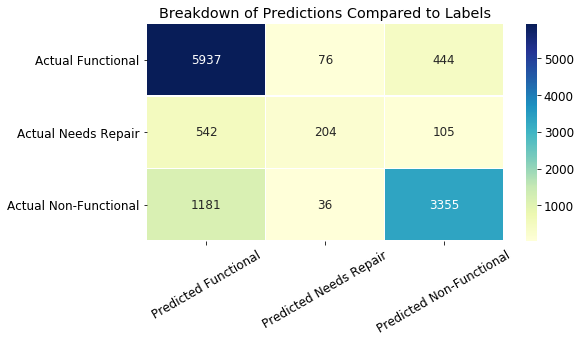

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(8,4))
sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=0.5, cmap="YlGnBu" )
plt.xticks(rotation=30)
plt.title('Breakdown of Predictions Compared to Labels')
plt.show()

## Visualize distribution of model predictions

In [42]:
bin_preds = pd.Series(y_pred_test).value_counts()

In [43]:
bin_preds

functional                 9238
non functional             4778
functional needs repair     342
dtype: int64

In [44]:
4774 / (9232 + 4774 + 352)

0.332497562334587

In [45]:
bin_preds = bin_preds.iloc[::-1]

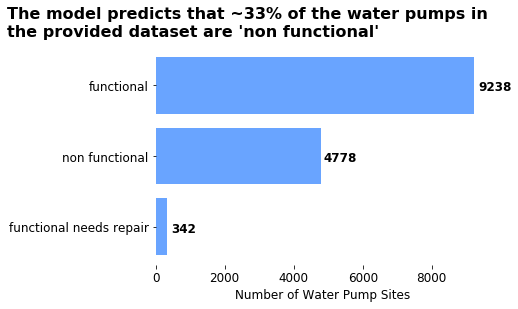

In [46]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
plt.barh(bin_preds.index, bin_preds.values, color='#69A4FF')
plt.xlabel('Number of Water Pump Sites')

plt.text(x=-4300,
        y=2.7, 
        s="The model predicts that ~33% of the water pumps in \nthe provided dataset are 'non functional'",
        fontsize=16,
        fontweight='bold')

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
for i, v in enumerate(bin_preds):
    plt.text(v + 100, i-0.075, str(v), color='black', fontweight='bold')
    
plt.savefig('Visualizations/step_1_predictions.png', bbox_inches='tight')

plt.show()

## Distribution of Predicted Probabilities

In [47]:
y_pred_proba_test = pd.DataFrame(y_pred_proba_test) 

In [48]:
non_functional_prob = y_pred_proba_test[2]

In [49]:
top_1260 = non_functional_prob.nlargest(1260)
top_1260_mod = pd.concat([top_1260, top_1260], axis=0)
top_1260_mod = top_1260_mod[:2160]

In [50]:
top_1260_mod.shape

(2160,)

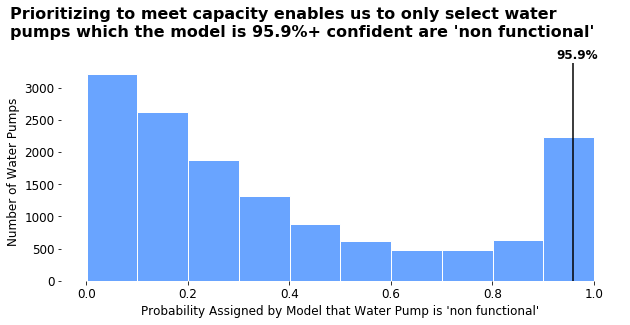

In [56]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(10,4))
plt.hist(non_functional_prob, edgecolor='white', color='#69A4FF')
plt.axvline(x=0.959404, color='black')
plt.xlabel("Probability Assigned by Model that Water Pump is 'non functional'")
plt.ylabel('Number of Water Pumps')
plt.text(x=-.15,
        y=3800, 
        s="Prioritizing to meet capacity enables us to only select water \npumps which the model is 95.9%+ confident are 'non functional'",
        fontsize=16,
        fontweight='bold')

plt.text(x=0.925,
        y=3450, 
        s="95.9%",
        fontsize=12,
        fontweight='bold')

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.savefig('Visualizations/step_2_pred_proba.png', bbox_inches='tight')
 
plt.show()

In [453]:
sort_prob = non_functional_prob.sort_values()

In [445]:
greater_90 = non_functional_prob[ non_functional_prob >= 0.9 ]

In [446]:
len(greater_90)

2159

In [460]:
X_test.shape

(14358, 83)

In [466]:
non_functional_prob.shape

(14358,)

In [467]:
X_test.head()

,amount_tsh,gps_height,basin_internal,basin_lake rukwa,basin_rufiji,basin_wami / ruvu,basin_lake victoria,basin_lake tanganyika,basin_pangani,basin_lake nyasa,...,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_hand pump,waterpoint_type_other,waterpoint_type_communal standpipe multiple,waterpoint_type_improved spring,waterpoint_type_cattle trough,waterpoint_type_dam,latitude,longitude
0,7702.857143,1996.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-4.059696,35.290799
1,1364.705882,1569.0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,-3.309214,36.656709
2,1440.961538,1567.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-5.004344,34.767863
3,398.333333,267.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-9.418672,38.058046
4,500.000000,1260.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-10.950412,35.006123


In [468]:
label_test = pd.concat([X_test, non_functional_prob], axis=1)

In [473]:
sorted_labels = label_test.sort_values(2, ascending=False)

In [478]:
top_1260_obs = sorted_labels.iloc[:1260,:]

In [486]:
lats = top_1260_obs['latitude'].tolist()
longs = top_1260_obs['longitude'].tolist()

In [491]:
top_1260_obs['latitude'].median(), top_1260_obs['longitude'].median()

(-7.091926455, 35.099646215)

In [504]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='mbrady4', api_key='Fo6d7PLhkZBamvE6ECCY')

mapbox_access_token = 'pk.eyJ1IjoibWJyYWR5NCIsImEiOiJjanZiOXd3M24xa3p6M3ludGl3YzljNXQ3In0.ymLirjOo-Yd2xlJjWXMNdg'


data = [
    go.Scattermapbox(
        lat=lats,
        lon=longs,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            color='#69A4FF',
            opacity=0.4
        )
    )
]

layout = go.Layout(
    title='The Prioritized Water Pumps for Repair are Spread Throughout the Country',
    width=700,
    height=700,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=-6.3,
            lon=35
        ),
        pitch=0,
        zoom=5,
        style='light'
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Impact Score
- Population + Distance + Probability 

In [506]:
# Standardize the Distance values to be within 0,1
from sklearn.preprocessing import minmax_scale

In [ ]:
# from sklearn.cluster import KMeans
# >>> import numpy as np
# >>> X = np.array([[1, 2], [1, 4], [1, 0],
# ...               [10, 2], [10, 4], [10, 0]])
# >>> kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
# >>> kmeans.labels_
# array([1, 1, 1, 0, 0, 0], dtype=int32)
# >>> kmeans.predict([[0, 0], [12, 3]])
# array([1, 0], dtype=int32)
# >>> kmeans.cluster_centers_
# array([[10.,  2.],
#        [ 1.,  2.]])

In [542]:
# Create location Clusters
from sklearn.cluster import KMeans
import numpy as np

locs = X_test[ ['longitude', 'latitude'] ]

kmeans = KMeans(n_clusters=5, random_state=0).fit(locs)

In [543]:
kmeans.labels_

array([1, 2, 1, ..., 1, 0, 0], dtype=int32)

In [544]:
clusters = kmeans.cluster_centers_

In [545]:
labels = pd.DataFrame(kmeans.labels_)

In [560]:
clusters

array([[34.2494489 , -9.1780558 ],
       [33.74452044, -3.26257543],
       [37.17339122, -4.41599886],
       [30.97656792, -3.40585839],
       [38.3734933 , -8.38271493]])

In [561]:
labels['cluster_long'] = labels[0].replace({
    0:clusters[0][0],
    1:clusters[1][0],
    2:clusters[2][0],
    3:clusters[3][0],
    4:clusters[4][0]
}, value=None)

labels['cluster_lat'] = labels[0].replace({
    0:clusters[0][1],
    1:clusters[1][1],
    2:clusters[2][1],
    3:clusters[3][1],
    4:clusters[4][1]
}, value=None)

In [562]:
distance_df = pd.concat([X_test, labels], axis=1)

In [563]:
labels.shape

(14358, 3)

In [564]:
distance_df.shape

(14358, 86)

In [566]:
distance_df['lat_from_cluster'] = distance_df['latitude'] - distance_df['cluster_lat']

In [567]:
distance_df['long_from_cluster'] = distance_df['longitude'] - distance_df['cluster_long']

In [571]:
distance_df['dist_from_cluster'] = (abs(distance_df['lat_from_cluster']) + abs(distance_df['long_from_cluster']) ) / 2

In [572]:
distance_df['distance'] = minmax_scale( distance_df['dist_from_cluster'], feature_range=(0,1) )

In [573]:
distance_df['population_scaled'] = minmax_scale( distance_df['population'], feature_range=(0,1) )

In [576]:
distance_df = pd.concat([distance_df, non_functional_prob], axis=1)

In [578]:
distance_df = distance_df.rename(columns={2:'non_func_prob'})

In [581]:
distance_df['impact_score'] = distance_df['non_func_prob'] + distance_df['population_scaled'] - distance_df['distance']

(array([ 109.,  663., 1940., 3488., 3248., 1649., 1627., 1075.,  549.,
          10.]),
 array([-0.792001  , -0.59846502, -0.40492905, -0.21139307, -0.0178571 ,
         0.17567888,  0.36921485,  0.56275083,  0.7562868 ,  0.94982277,
         1.14335875]),
 <a list of 10 Patch objects>)

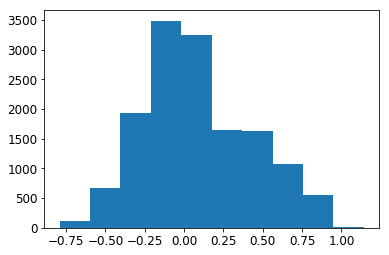

In [585]:
plt.hist(distance_df['impact_score'])

In [586]:
distance_df = distance_df.sort_values('impact_score', ascending=False)

In [589]:
top_impact = distance_df.iloc[:1260]

In [669]:
top_impact['population'].sum()

597744.0540429007

In [592]:
top_impact['non_func_prob'].mean()

0.9224739311233259

In [594]:
impact_lats = top_impact['latitude']
impact_longs = top_impact['longitude']

In [595]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='mbrady4', api_key='Fo6d7PLhkZBamvE6ECCY')

mapbox_access_token = 'pk.eyJ1IjoibWJyYWR5NCIsImEiOiJjanZiOXd3M24xa3p6M3ludGl3YzljNXQ3In0.ymLirjOo-Yd2xlJjWXMNdg'


data = [
    go.Scattermapbox(
        lat=impact_lats,
        lon=impact_longs,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            color='#69A4FF',
            opacity=0.4
        )
    )
]

layout = go.Layout(
    title='The Prioritized Water Pumps for Repair are Spread Throughout the Country',
    width=700,
    height=700,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=-6.3,
            lon=35
        ),
        pitch=0,
        zoom=5,
        style='light'
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [600]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='mbrady4', api_key='Fo6d7PLhkZBamvE6ECCY')

mapbox_access_token = 'pk.eyJ1IjoibWJyYWR5NCIsImEiOiJjanZiOXd3M24xa3p6M3ludGl3YzljNXQ3In0.ymLirjOo-Yd2xlJjWXMNdg'


data = [
    go.Scattermapbox(
        lat=lats,
        lon=longs,
        mode='markers',
        name='De-Prioritized Sites',
        marker=go.scattermapbox.Marker(
            size=10,
            color='#808080',
            opacity=0.2
        )
    ),
    go.Scattermapbox(
        lat=impact_lats,
        lon=impact_longs,
        mode='markers',
        name='Prioritized Sites',
        marker=go.scattermapbox.Marker(
            size=10,
            color='#69A4FF',
            opacity=0.4
        )
    )
]

layout = go.Layout(
    title='Did we create unintended consequences based on our definition of impact?',
    width=900,
    height=700,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=-6.3,
            lon=35
        ),
        pitch=0,
        zoom=5,
        style='light'
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [671]:
val_pred_proba

NameError: name 'val_pred_proba' is not defined